# 0. Setup

In [11]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# Configuration
NUM_TRIALS = 10  # Number of Monte Carlo runs
RANDOM_SEED = 42  # For reproducibility
COLORS = [0, 1, 2, 3, 4, 5]
POSITIONS = 4

# Generate all possible codes
ALL_CODES = np.array(list(itertools.product(COLORS, repeat=POSITIONS)), dtype=np.int8)
N_CODES = len(ALL_CODES)

# Feedback encoding: Map (Black, White) pegs to integer indices
FEEDBACK_MAP = {
    (0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3, (0,4): 4,
    (1,0): 5, (1,1): 6, (1,2): 7, (1,3): 8,
    (2,0): 9, (2,1): 10, (2,2): 11,
    (3,0): 12,
    (4,0): 13,  # Win condition
}
MAX_FEEDBACK_VAL = 14

print(f"Total possible codes: {N_CODES}")

Total possible codes: 1296


# 1. Precompute Feedback Matrix

In [14]:
# 1. Precompute Feedback Matrix
def get_feedback(secret, guess):
    """
    Calculate Mastermind feedback.
    Returns: Integer index from FEEDBACK_MAP representing (black, white) pegs.
    """
    black = 0
    s_counts = [0] * 6
    g_counts = [0] * 6
    
    # Count exact matches (black pegs) and color frequencies
    for i in range(POSITIONS):
        if secret[i] == guess[i]:
            black += 1
        else:
            s_counts[secret[i]] += 1
            g_counts[guess[i]] += 1
    
    # Count color matches in wrong positions (white pegs)
    white = sum(min(s_counts[c], g_counts[c]) for c in range(6))
    
    return FEEDBACK_MAP.get((black, white), 0)

# Build interaction matrix: FEEDBACK_MATRIX[guess_idx, secret_idx]
print("Building feedback matrix...")
FEEDBACK_MATRIX = np.zeros((N_CODES, N_CODES), dtype=np.uint8)

for i in range(N_CODES):
    for j in range(N_CODES):
        FEEDBACK_MATRIX[i, j] = get_feedback(ALL_CODES[i], ALL_CODES[j])

print(FEEDBACK_MATRIX)

Building feedback matrix...
[[13 12 12 ...  0  0  0]
 [12 13 12 ...  0  0  0]
 [12 12 13 ...  0  0  0]
 ...
 [ 0  0  0 ... 13 12 12]
 [ 0  0  0 ... 12 13 12]
 [ 0  0  0 ... 12 12 13]]


# 2. Find All Best First Guesses

In [15]:
def calculate_entropy_vectorized(candidates_indices):
    """
    Calculate information entropy for all possible guesses.
    
    Args:
        candidates_indices: Remaining valid secret codes
    
    Returns:
        Array of entropy values for each possible guess
    """
    n_candidates = len(candidates_indices)
    if n_candidates == 1:
        return np.zeros(N_CODES)

    sub_matrix = FEEDBACK_MATRIX[:, candidates_indices]
    entropies = np.zeros(N_CODES)
    
    for guess_idx in range(N_CODES):
        # Count frequency of each feedback outcome
        counts = np.bincount(sub_matrix[guess_idx], minlength=MAX_FEEDBACK_VAL + 1)
        probs = counts[counts > 0] / n_candidates
        # Shannon entropy: -Σ(p * log2(p))
        entropies[guess_idx] = -np.sum(probs * np.log2(probs))
    
    return entropies

# Find all first guesses with maximum entropy
print("Calculating optimal first guesses...")
all_candidates = np.arange(N_CODES)
first_guess_entropies = calculate_entropy_vectorized(all_candidates)

max_entropy = np.max(first_guess_entropies)
BEST_FIRST_GUESSES = np.where(first_guess_entropies >= max_entropy - 1e-6)[0]

print(f"Found {len(BEST_FIRST_GUESSES)} optimal first guesses")
print(f"Maximum entropy: {max_entropy:.4f} bits")
print(f"Examples: {[ALL_CODES[i].tolist() for i in BEST_FIRST_GUESSES[:5]]}")

Calculating optimal first guesses...
Found 360 optimal first guesses
Maximum entropy: 3.0567 bits
Examples: [[0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 2, 5], [0, 1, 3, 2], [0, 1, 3, 4]]


# 3. Solver Logic

In [4]:
def solve_single_game_randomized(secret_idx, first_guess_idx, rng):
    """
    Solves for a single secret index using Max Entropy.
    RANDOMIZES the choice at every turn when there are multiple 
    guesses with equal maximum entropy.
    
    Args:
        secret_idx: Index of the secret code
        first_guess_idx: Index of the first guess to use
        rng: numpy random generator for this game (for reproducibility)
    
    Returns:
        Number of steps taken
    """
    candidates_indices = np.arange(N_CODES)
    steps = 0
    guess_idx = first_guess_idx
    
    while True:
        steps += 1
        
        # Check against the secret
        actual_feedback = FEEDBACK_MATRIX[guess_idx, secret_idx]
        
        if actual_feedback == 13:  # (4,0) - Win
            return steps
        
        # Filter candidates
        matches = (FEEDBACK_MATRIX[guess_idx, candidates_indices] == actual_feedback)
        candidates_indices = candidates_indices[matches]
        
        # Determine next guess
        if len(candidates_indices) == 1:
            guess_idx = candidates_indices[0]
        else:
            # Calculate entropy for all potential guesses
            entropies = calculate_entropy_vectorized(candidates_indices)
            
            # Find max entropy
            max_ent = np.max(entropies)
            
            # Get indices of all guesses that have this max entropy
            best_guesses = np.where(entropies >= max_ent - 1e-6)[0]
            
            # TIE BREAKER WITH RANDOMIZATION:
            # Prefer a guess that is a valid candidate
            intersection = np.intersect1d(best_guesses, candidates_indices)
            
            if len(intersection) > 0:
                # RANDOMIZE among valid candidates with max entropy
                guess_idx = rng.choice(intersection)
            else:
                # RANDOMIZE among all max-entropy guesses
                guess_idx = rng.choice(best_guesses)
                
    return steps

# 4. Run Multiple Trials

In [19]:
import time

print(f"Running {NUM_TRIALS} trials with randomized tie-breaking...\n")

master_rng = np.random.default_rng(RANDOM_SEED)
all_trial_results = []
trial_first_guesses = []

start_time = time.time()

for trial in range(NUM_TRIALS):
    # Select random optimal first guess
    first_guess_idx = master_rng.choice(BEST_FIRST_GUESSES)
    trial_first_guesses.append(first_guess_idx)
    
    # Generate unique seeds for each game
    game_seeds = master_rng.integers(0, 2**31, size=N_CODES)
    
    # Solve all 1296 games in parallel
    results = Parallel(n_jobs=-1)(
        delayed(solve_single_game_randomized)(
            i, 
            first_guess_idx,
            np.random.default_rng(game_seeds[i])
        ) 
        for i in tqdm(range(N_CODES), desc=f"Trial {trial + 1}/{NUM_TRIALS}")
    )
    
    all_trial_results.append(results)
    
    # Trial statistics
    avg_steps = np.mean(results)
    worst_steps = np.max(results)
    print(f"Trial {trial + 1}: Avg={avg_steps:.4f}, Worst={worst_steps}")

elapsed = time.time() - start_time
print(f"\nTotal computation time: {elapsed:.2f} seconds")

Running 10 trials with randomized tie-breaking...



Trial 1/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 1: Avg=4.4252, Worst=6


Trial 2/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 2: Avg=4.4244, Worst=6


Trial 3/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 3: Avg=4.4344, Worst=6


Trial 4/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 4: Avg=4.4159, Worst=6


Trial 5/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 5: Avg=4.4437, Worst=6


Trial 6/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 6: Avg=4.4059, Worst=6


Trial 7/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 7: Avg=4.4167, Worst=6


Trial 8/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 8: Avg=4.4043, Worst=6


Trial 9/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 9: Avg=4.4097, Worst=6


Trial 10/10:   0%|          | 0/1296 [00:00<?, ?it/s]

Trial 10: Avg=4.4074, Worst=6

Total computation time: 302.64 seconds


# 5. Aggregate

In [23]:
# Convert to numpy array for easier manipulation
all_trial_results = np.array(all_trial_results)  # Shape: (NUM_TRIALS, N_CODES)

# Build histogram data
all_step_counts = {}
for trial_results in all_trial_results:
    step_counter = Counter(trial_results)
    for steps, count in step_counter.items():
        if steps not in all_step_counts:
            all_step_counts[steps] = []
        all_step_counts[steps].append(count)

# Calculate average frequencies
steps = sorted(all_step_counts.keys())
avg_frequencies = []

for s in steps:
    counts = all_step_counts[s]
    counts_padded = counts + [0] * (NUM_TRIALS - len(counts))
    avg_frequencies.append(np.mean(counts_padded))

# Debug: Show distribution
step_dist = {int(s): float(f) for s, f in zip(steps, avg_frequencies)}
print(f"\nStep distribution: {step_dist}")

# Calculate overall average
overall_avg = np.mean(all_trial_results)
print(f"Overall average: {overall_avg:.4f}")


Step distribution: {1: 1.0, 2: 5.6, 3: 71.7, 4: 601.5, 5: 603.8, 6: 12.4}
Overall average: 4.4188


# 6. Plotting

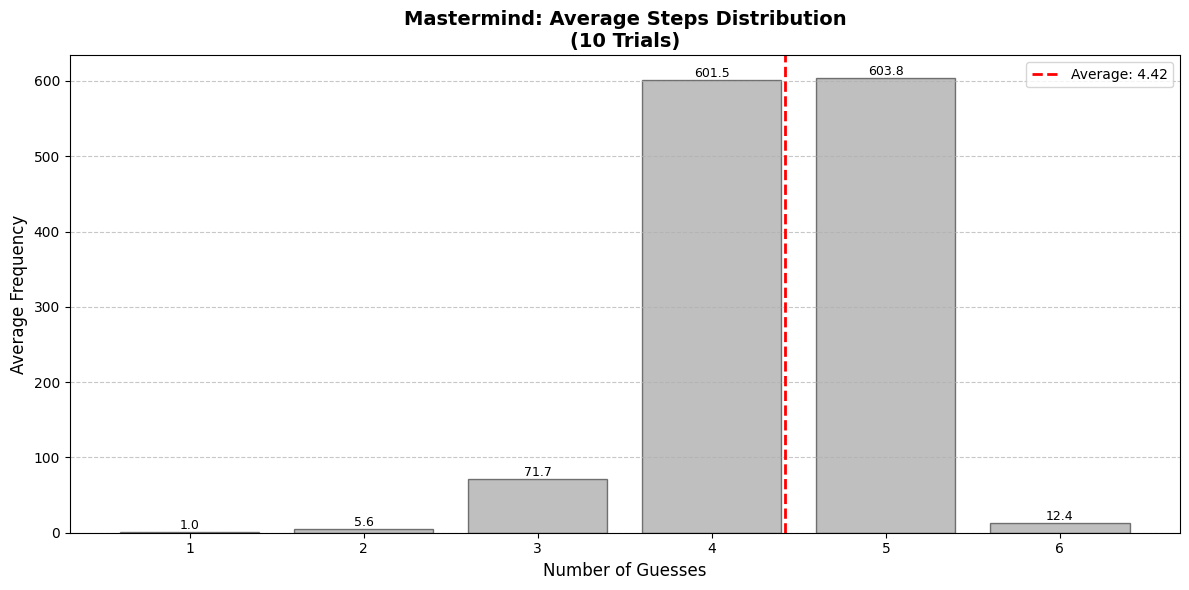

In [24]:
plt.figure(figsize=(12, 6))

bars = plt.bar(steps, avg_frequencies, 
               color='gray', edgecolor='black', 
               alpha=0.5)

plt.title(f'Mastermind: Average Steps Distribution\n({NUM_TRIALS} Trials)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Number of Guesses', fontsize=12)
plt.ylabel('Average Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(steps)

# Add text labels on bars
for bar, avg_f in zip(bars, avg_frequencies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{avg_f:.1f}',
             ha='center', va='bottom', fontsize=9)

plt.axvline(overall_avg, color='red', linestyle='dashed', 
            linewidth=2, label=f'Average: {overall_avg:.2f}')
plt.legend()
plt.tight_layout()
plt.show()